# 01. Data Exploration and Preprocessing

## 0. Imports & Setup

### 0.1 Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import STOPWORDS
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import spacy, os, re, string, torch, language_tool_python, tqdm

# Enable GPU support for spaCy if available
spacy.prefer_gpu()      #type: ignore

if spacy.prefer_gpu():  #type: ignore
    print("Using GPU for spaCy")
else:
    print("Using CPU for spaCy")

# Enable GPU support for PyTorch if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: GPU enabled for PyTorch")

# Set up plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
%matplotlib inline

# !python -m spacy download en_core_web_trf

Using CPU for spaCy
Using device: GPU enabled for PyTorch


## 1. Data Loading

### 1.1 Combine All Data with Confidence Rates and Save

Download and load the Financial PhraseBank dataset
- Dataset URL: https://www.researchgate.net/publication/251231107_FinancialPhraseBank-v10

In [71]:
# File paths for all agreement levels
file_50_agree = '../data/raw/Sentences_50Agree.txt'
file_66_agree = '../data/raw/Sentences_66Agree.txt'
file_75_agree = '../data/raw/Sentences_75Agree.txt'
file_100_agree = '../data/raw/Sentences_100Agree.txt'

# Temporary list to hold data
data_list = []

# Helper: Extract confidence from filename
def extract_confidence(file_path):
    fname = os.path.basename(file_path).lower()
    if '100agree' in fname:
        return 1.00
    elif '75agree' in fname:
        return 0.75
    elif '66agree' in fname:
        return 0.66
    elif '50agree' in fname:
        return 0.50
    else:
        return None  # Unknown confidence

# Load files
for file_path in [file_50_agree, file_66_agree, file_75_agree, file_100_agree]:
    confidence = extract_confidence(file_path)
    if confidence is None:
        print(f"⚠️  Could not determine confidence for: {file_path}")
        continue
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        loaded_count = 0
        with open(file_path, 'r', encoding='latin1') as file:
            for line in file:
                line = line.strip()
                if line and '@' in line:
                    parts = line.split('@')
                    if len(parts) == 2:
                        text, sentiment = parts
                        data_list.append({
                            'text': text.strip(),
                            'sentiment': sentiment.strip(),
                            'confidence': confidence
                        })
                        loaded_count += 1
        print(f"  Loaded {loaded_count} sentences with {int(confidence*100)}% agreement")
    else:
        print(f"⚠️  File not found: {file_path}")

# Create DataFrame
if data_list:
    df = pd.DataFrame(data_list)
    
    # Save the combined dataset
    output_path = '../data/processed/financial_phrasebank_all_confidence.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Dataset saved to: {output_path}")
else:
    print("❌ No data loaded. Please check if the files exist and have correct format.")

Loading ../data/raw/Sentences_50Agree.txt...
  Loaded 4846 sentences with 50% agreement
Loading ../data/raw/Sentences_66Agree.txt...
  Loaded 4217 sentences with 66% agreement
Loading ../data/raw/Sentences_75Agree.txt...
  Loaded 3453 sentences with 75% agreement
Loading ../data/raw/Sentences_100Agree.txt...
  Loaded 2264 sentences with 100% agreement

💾 Dataset saved to: ../data/processed/financial_phrasebank_all_confidence.csv


## 2. Basic EDA

### 2.1 Dataframe Head Sample

In [ ]:
df.head()

In [ ]:
print("First 5 texts before cleaning:")
for i, text in enumerate(df['text'].head()):
    print(f"{i+1}: {text}")
    if i >= 4:  # Only show first 5
        break
    print("-" * 80)

First 5 texts before cleaning:
1: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
--------------------------------------------------------------------------------
2: Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
--------------------------------------------------------------------------------
3: The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
--------------------------------------------------------------------------------
4: With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore

### 2.2 Data types

In [73]:
print(f"Data types of the database (column, data type): \n{df.dtypes}")

Data types of the database (column, data type): 
text           object
sentiment      object
confidence    float64
dtype: object


### 2.3 Missing Values

In [74]:
df.isnull().sum()

text          0
sentiment     0
confidence    0
dtype: int64

### 2.4 Duplicate Texts

In [75]:
df['text'].duplicated().sum()  # Check for duplicate texts

9942

In [76]:
# Remove duplicates, keeping only the highest confidence version
df = df.sort_values('confidence', ascending=False).drop_duplicates(subset='text', keep='first').reset_index(drop=True)
print(f"After removing lower-confidence duplicates, shape: {df.shape}")

After removing lower-confidence duplicates, shape: (4838, 3)


In [77]:
df['text'].duplicated().sum()  # Check again for duplicates

0

In [78]:
df['text'].count()  # Print the number of unique texts

4838

## 3. Preprocessing - Text Sanitisation

### 3.1 Identify Very Short or Very Long Texts

In [79]:
# Text length distribution
df['text_length_chars'] = df['text'].str.len()
df['text_length_words'] = df['text'].str.split().str.len()

# Print number of texts with less than 10 words and more than 100 words
num_short = (df['text'].str.split().str.len() < 10).sum()
num_long = (df['text'].str.split().str.len() > 100).sum()
print(f"Number of texts with less than 10 words: {num_short}")
print(f"Number of texts with more than 100 words: {num_long}")

Number of texts with less than 10 words: 220
Number of texts with more than 100 words: 0


In [80]:
# Filter out texts with less than 10 words or more than 100 words
df = df[df['text'].str.split().str.len().between(10, 100)].reset_index(drop=True)

In [81]:
# Print number of texts with less than 10 words and more than 100 words
num_short = (df['text'].str.split().str.len() < 10).sum()
num_long = (df['text'].str.split().str.len() > 100).sum()
print(f"Number of texts with less than 10 words: {num_short}")
print(f"Number of texts with more than 100 words: {num_long}")
print(f"DataFrame shape {df.shape}")  # Print the shape of the DataFrame after filtering

Number of texts with less than 10 words: 0
Number of texts with more than 100 words: 0
DataFrame shape (4618, 5)


### 3.2 Text Sanitisation

**Preserving Financial Symbols**

In [82]:
# ---------------------------------------------------------------------------- #
#                            CHARACTERS TO PRESERVE                            #
# ---------------------------------------------------------------------------- #

# ------------- DEFINE FINANCIAL AND CURRENCY SYMBOLS TO PRESERVE ------------ #
financial_symbols = {
    # Currency symbols
    '$', '€', '£', '¥', '₹', '₽', '₩', '₪', '₡', '₨', '₦', '₵', '₴', '₸', '₼',
    # Financial notation
    '%', '+', '-', '=', '(', ')', '.', ',', ';', ':', 
    # Quotation marks (often used in financial context)
    '"', "'", '!', '?'
    # Add ampersand since we handle it in cleaning
    '&'
}

# ------------------ REMOVE ENCODING ARTIFACTS AND NON-ASCII ----------------- #
encoding_artifacts = [
    # Unicode replacement characters
    '�', '\ufffd',
    # Null and control characters  
    '\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08',
    '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14',
    '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d',
    '\x1e', '\x1f', '\x7f',
    # Common encoding artifacts
    '\\x', '\\u', '\\n', '\\t', '\\r',
    # Byte order marks
    '\ufeff', '\ufffe'
]

# --------------------- STANDARD ALPHANUMERIC CHARACTERS --------------------- #
standard_chars = set(string.ascii_letters + string.digits + ' ')

# ------------------------- ALL ACCEPTABLE CHARACTERS ------------------------ #
acceptable_chars = financial_symbols | standard_chars

**Grammar Correction Tool Setup**

In [83]:
# ---------------------------------------------------------------------------- #
#                           GRAMMAR CORRECTION SETUP                           #
# ---------------------------------------------------------------------------- #

# Initialize LanguageTool (do this once globally for efficiency)
try:
    grammar_tool = language_tool_python.LanguageTool('en-US')
    GRAMMAR_CORRECTION_ENABLED = True #TODO: ADD THIS TO CONFIG INSTEAD
    print("LanguageTool initialized successfully")
except Exception as e:
    print(f"LanguageTool initialization failed: {e}")
    print("   Grammar correction will be skipped")
    GRAMMAR_CORRECTION_ENABLED = False

LanguageTool initialized successfully


**Functions**

In [84]:
def remove_encoding_artifacts_and_non_ascii(text):
    """
    Remove encoding artifacts and non-ASCII characters from the text.
    Args:
        text (str): The text to clean.
    Returns:
        str: The cleaned text with encoding artifacts and non-ASCII characters removed.
    """
    # Remove encoding artifacts
    for artifact in encoding_artifacts:
        text = text.replace(artifact, ' ')
    
    # Remove non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)

    return text

In [85]:

def clean_urls_from_text(text):
    """
    Remove URLs and web links from the text.
    Args:
        text (str): The text to clean.
    Returns:
        str: The cleaned text with URLs removed.
    """
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[a-zA-Z0-9-]+\.(com|org|net|gov|edu|co\.uk|de|fr|it|es)', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    return text

In [86]:
def convert_financial_abbreviations_in_text(text):
    """
    Expand financial abbreviations in the text.
    Args:
        text (str): The text to process.
    Returns:
        str: The text with financial abbreviations expanded.
    """
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*mn\b', r'\1 million', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*bn\b', r'\1 billion', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*tn\b', r'\1 trillion', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*k\b', r'\1 thousand', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*M\b(?!\w)', r'\1 million', text)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*B\b(?!\w)', r'\1 billion', text)
    
    return text

In [87]:
def replace_symbols_with_text(text):
    """
    Replace symbols with their text equivalents in the text.
    Args:
        text (str): The text to process.
    Returns:
        str: The text with symbols replaced by their text equivalents.
    """
    text = re.sub(r'\s*&\s*', ' and ', text)
    text = re.sub(r'\bpct\b', 'percent', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq1\b', 'first quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq2\b', 'second quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq3\b', 'third quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq4\b', 'fourth quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\byoy\b', 'year over year', text, flags=re.IGNORECASE)
    text = re.sub(r'\bqoq\b', 'quarter over quarter', text, flags=re.IGNORECASE)
    
    return text

In [88]:
def clean_consecutive_punctuation(text):
    """
    Remove multiple consecutive punctuation marks, keeping a maximum of two.
    Args:
        text (str): The text to process.
    Returns:
        str: The text with cleaned punctuation.
    """
    text = re.sub(r'([.]{3,})', '...', text)    # Keep ellipsis
    text = re.sub(r'([!]{2,})', '!', text)      # Reduce multiple exclamations
    text = re.sub(r'([`]{2,})', '`', text)      # Reduce multiple backticks
    text = re.sub(r'([?]{2,})', '?', text)      # Reduce multiple questions
    text = re.sub(r'([,]{2,})', ',', text)      # Remove multiple commas
    text = re.sub(r'([;]{2,})', ';', text)      # Remove multiple semicolons
    text = re.sub(r'([:]{2,})', ':', text)      # Remove multiple colons
    text = re.sub(r'(["\']){2,}', r'\1', text)  # Replace multiple quotes with a single quote
    text = re.sub(r'([(]){2,}', '(', text)      # Replace multiple opening parentheses
    text = re.sub(r'([)]){2,}', ')', text)      # Replace multiple closing parentheses
    text = re.sub(r'([{]){2,}', '{', text)      # Replace multiple opening curly braces
    text = re.sub(r'([}]){2,}', '}', text)      # Replace multiple closing curly braces
    text = re.sub(r'([\[]){2,}', '[', text)     # Replace multiple opening square brackets
    text = re.sub(r'([\]]){2,}', ']', text)     # Replace multiple closing square brackets

    return text

In [89]:
def fix_whitespace(text):
    """
    Fix spacing around punctuation in the text.
    Args:
        text (str): The text to process.
    Returns:
        str: The text with fixed spacing around punctuation.
    """    
    text = re.sub(r'\s+([,.;:!?%])', r'\1', text)            # Remove space before punctuation
    text = re.sub(r'([,.;:!?%])(?=[A-Za-z])', r'\1 ', text)  # Add space after punctuation if needed
    text = re.sub(r'([,.;:!?%])\s+', r'\1 ', text)           # Normalize multiple spaces after punctuation
    text = re.sub(r'\s+', ' ', text)                         # Normalize multiple spaces to a single space
    text = re.sub(r'^\s+|\s+$', '', text)                    # Remove leading and trailing whitespace

    return text

In [90]:
def apply_grammar_correction(text, max_length_for_grammar=300):
    """
    Apply grammar correction to the text if conditions are met.
    Args:
        text (str): The text to correct.
        max_length_for_grammar (int): Maximum length of text for grammar correction.
    Returns:
        str: The corrected text if applicable, otherwise the original text.
    """
    if GRAMMAR_CORRECTION_ENABLED and len(text) <= max_length_for_grammar:
        try:
            corrected_text = grammar_tool.correct(text)
            # Only use corrected version if it's not empty
            if corrected_text.strip():
                text = corrected_text
        except Exception as e:
            # If grammar correction fails, continue with cleaned text
            print(f"Grammar correction failed for text: {text[:50]}... Error: {e}")
    
    return text

In [91]:
def cleanup_grammar_tool():
    """Close the LanguageTool instance to free resources"""
    if GRAMMAR_CORRECTION_ENABLED and 'grammar_tool' in globals():
        try:
            grammar_tool.close()
            print("LanguageTool closed successfully")
        except:
            pass

In [92]:
def clean_text(texts, correct_grammar=True, batch_size=100, max_length_for_grammar=300):
    """
    Clean a pandas Series of texts by applying various text preprocessing steps.
    
    Args:
        texts (pd.Series): Series of texts to clean
        correct_grammar (bool): Whether to apply grammar correction
        batch_size (int): Size of batches for processing
        max_length_for_grammar (int): Maximum text length for grammar correction
    
    Returns:
        pd.Series: Cleaned texts that can be directly assigned to df['text']
    """    
    # ----------------------------------- SETUP ---------------------------------- #
    print(f"Processing {len(texts)} texts...")
    print(f"Grammar correction: {'Enabled' if correct_grammar and GRAMMAR_CORRECTION_ENABLED else 'Disabled'}")

    # Convert to pandas Series if it's a list
    if isinstance(texts, list):
        texts = pd.Series(texts)
    
    # Create backup of original data
    original_texts = texts.copy()
    
    # Track corrections
    corrections_made = 0
    grammar_corrections = 0
    # ---------------------------------------------------------------------------- #

    # ----------------------- DISPLAY PRE-CLEANING VERSION ----------------------- #
    print("First 5 texts before cleaning:")
    for i, text in enumerate(texts.head()):
        print(f"{i+1}: {text}")
        if i >= 4:  # Only show first 5
            break
    print("-" * 80)
    # ---------------------------------------------------------------------------- #
    
    # ---------------------------- PROCESS IN BATCHES ---------------------------- #
    cleaned_texts = texts.copy()
    
    for start in tqdm.tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        end = min(start + batch_size, len(texts))
        batch_indices = texts.index[start:end]
        
        # Clean each text in the batch
        for idx in batch_indices:
            text = texts.loc[idx]
            original_text = original_texts.loc[idx]
            
            # Apply cleaning functions
            text = remove_encoding_artifacts_and_non_ascii(text)
            text = clean_urls_from_text(text)
            text = convert_financial_abbreviations_in_text(text)
            text = replace_symbols_with_text(text)
            text = clean_consecutive_punctuation(text)
            text = fix_whitespace(text)
            text = apply_grammar_correction(text, max_length_for_grammar) if correct_grammar and GRAMMAR_CORRECTION_ENABLED else text
                        
            # Update cleaned texts
            cleaned_texts.loc[idx] = text
            
            # Track corrections
            corrections_made += 1
            if original_text != text:
                grammar_corrections += 1
    # ---------------------------------------------------------------------------- #
    
    cleanup_grammar_tool()  # Close LanguageTool to free resources

    print(f"\n✅ Processing complete:")
    print(f"  - Total corrections made: {corrections_made}")
    print(f"  - Estimated grammar corrections: {grammar_corrections}")

    # ----------------------- DISPLAY POST-CLEANING VERSION ---------------------- #
    print("First 5 texts after cleaning:")
    for i, text in enumerate(cleaned_texts.head()):
        print(f"{i+1}: {text}")
        if i >= 4:  # Only show first 5
            break
    print("-" * 80)
    # ---------------------------------------------------------------------------- #

    return cleaned_texts

In [93]:
df['text'] = clean_text(df['text'])

Processing 4618 texts...
Grammar correction: Enabled
First 5 texts before cleaning:
1: Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .
2: Mika Stahlberg , VP F-Secure Labs , said , `` We are excited and proud that F-Secure has been recognized by AV-Comparatives as the Product of the Year .
3: Any investment or investment activity to which this communication relates is only available to relevant persons and will be engaged in only with relevant persons .
4: And that 's exactly what happened on a recent weekday when an East Haven baker was brought in to remind residents about the Easter tradition of making wheat and rice pies .
5: According to an  posted by the World Intellectual Property Organization : `` The present invention relates to hydrocarbons and particularly to the manufacture of hydrocarbon components suitable as aviation fuels or jet fuels and as blending stocks for aviation fuels .
----------------------------------------------

Processing batches: 100%|██████████| 47/47 [02:28<00:00,  3.16s/it]


LanguageTool closed successfully

✅ Processing complete:
  - Total corrections made: 4618
  - Estimated grammar corrections: 4616
First 5 texts after cleaning:
1: Sales in Finland decreased by 10.5% in January, while sales outside Finland dropped by 17%.
2: Mika Stahl berg, VP F-Secure Labs, said, ` We are excited and proud that F-Secure has been recognized by AV-Comparatives as the Product of the Year.
3: Any investment or investment activity to which this communication relates is only available to relevant persons and will be engaged in only with relevant persons.
4: And that's exactly what happened on a recent weekday when an East Haven baker was brought in to remind residents about the Easter tradition of making wheat and rice pies.
5: According to a posted by the World Intellectual Property Organization: ` The present invention relates to hydrocarbons and particularly to the manufacture of hydrocarbon components suitable as aviation fuels or jet fuels and as blending stocks for av

### 3.3 Print Clean Text

In [94]:
for i, text in enumerate(df['text'].head()):
    print(f"\nExample {i+1}:")
    print(f"Text: {text}")
    print(f"Sentiment: {df.iloc[i]['sentiment']}")
    print(f"Confidence: {df.iloc[i]['confidence']}")
    print("-" * 80)


Example 1:
Text: Sales in Finland decreased by 10.5% in January, while sales outside Finland dropped by 17%.
Sentiment: negative
Confidence: 1.0
--------------------------------------------------------------------------------

Example 2:
Text: Mika Stahl berg, VP F-Secure Labs, said, ` We are excited and proud that F-Secure has been recognized by AV-Comparatives as the Product of the Year.
Sentiment: positive
Confidence: 1.0
--------------------------------------------------------------------------------

Example 3:
Text: Any investment or investment activity to which this communication relates is only available to relevant persons and will be engaged in only with relevant persons.
Sentiment: neutral
Confidence: 1.0
--------------------------------------------------------------------------------

Example 4:
Text: And that's exactly what happened on a recent weekday when an East Haven baker was brought in to remind residents about the Easter tradition of making wheat and rice pies.
Sen

## 4. Advanced EDA - Sentiment Distribution Analysis 

### 4.1 Sentiment Distribution Analysis

Sentiment distribution:


Text(0, 0.5, '')

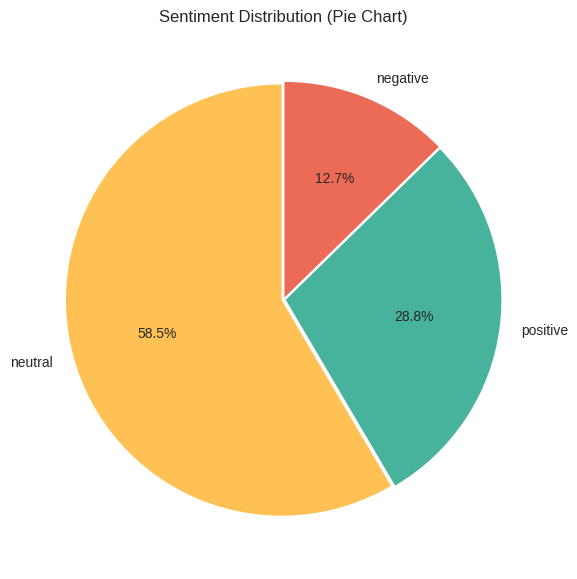

In [95]:
# -------------------------- SENTIMENT DISTRIBUTION -------------------------- #
print("Sentiment distribution:")
df['sentiment'].value_counts()
# ---------------------------------------------------------------------------- #

# ------------------- PIE CHART FOR SENTIMENT DISTRIBUTION ------------------- #
plt.figure(figsize=(7, 7))
df['sentiment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#FFC154', '#47B39C', '#EC6B56'],
    startangle=90,
    explode=[0.01, 0.01, 0.01]
)
plt.title('Sentiment Distribution (Pie Chart)')
plt.ylabel('')
# ---------------------------------------------------------------------------- #

## 5. Advanced EDA - Text Characteristics Analysis

### 5.1 Text Length Distribution

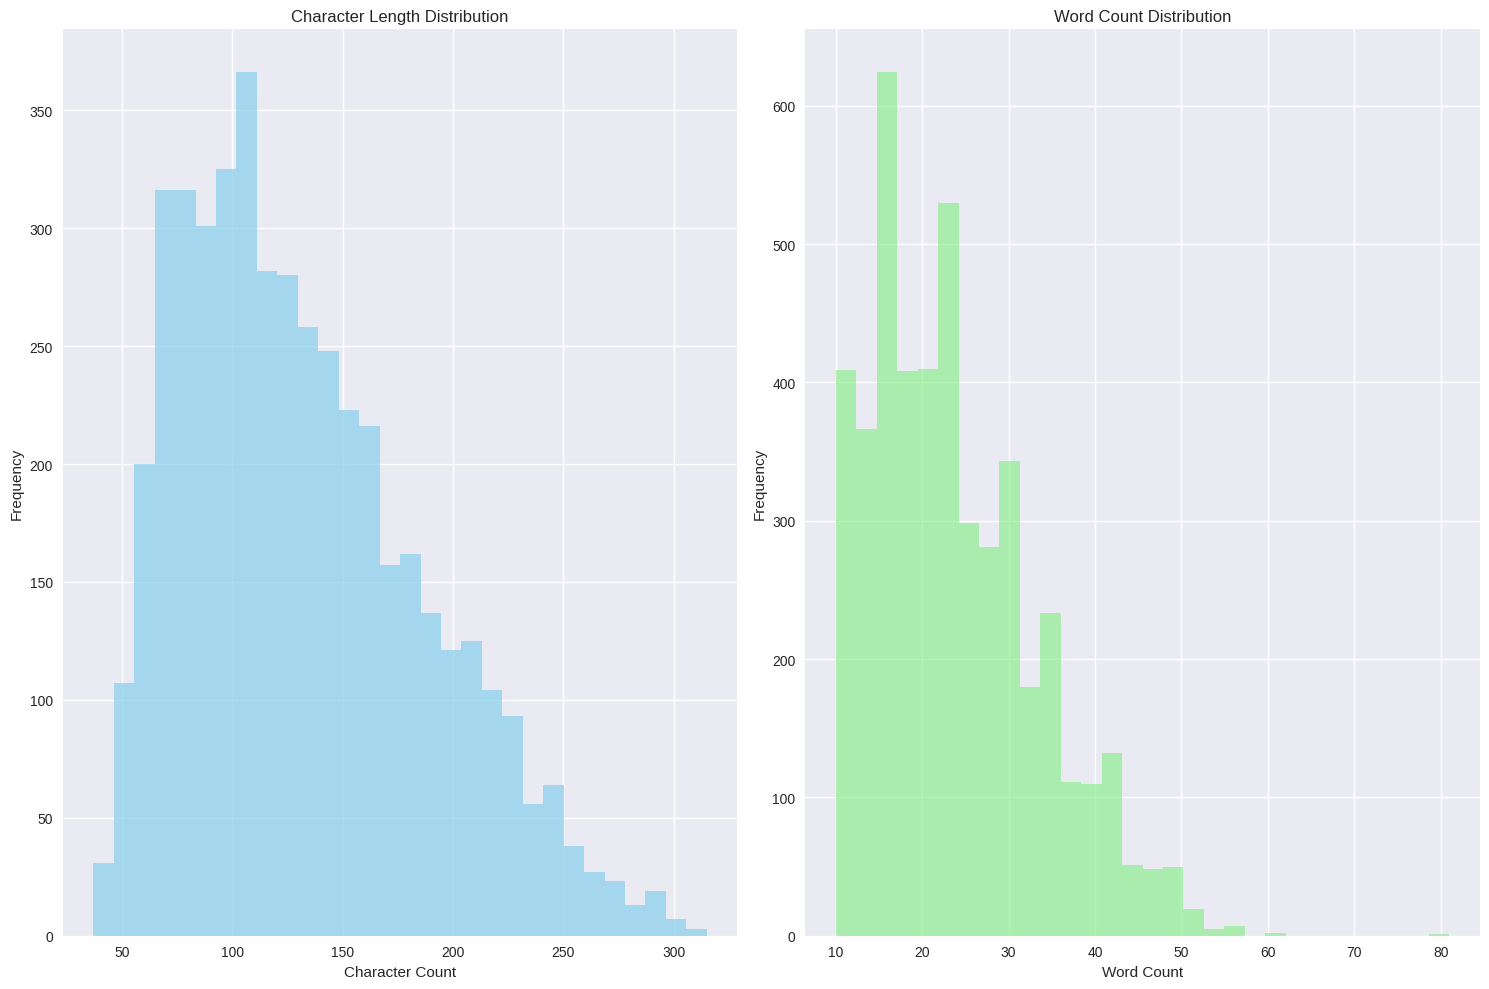

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Character length histogram
axes[0].hist(df['text_length_chars'], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

# Word count histogram
axes[1].hist(df['text_length_words'], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 5.2 Most Common Words For Sentiment Classes

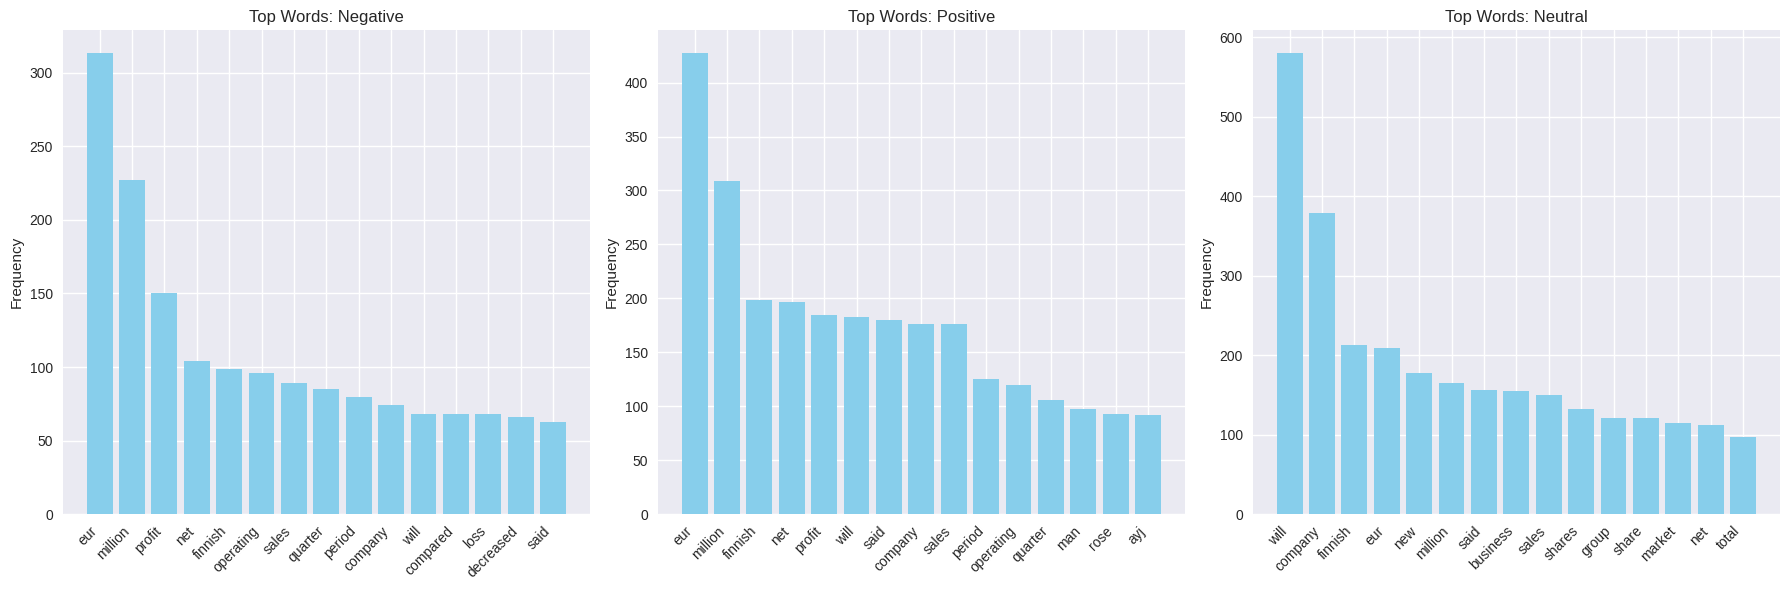

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sentiments = df['sentiment'].unique()
for i, sentiment in enumerate(sentiments):
    words = df[df['sentiment'] == sentiment]['text'].str.lower().str.split().sum()
    filtered_words = [w for w in words if w not in STOPWORDS and w.isalpha()]
    common_words = Counter(filtered_words).most_common(15)
    labels, values = zip(*common_words)
    axes[i].bar(labels, values, color='skyblue')
    axes[i].set_title(f"Top Words: {sentiment.capitalize()}")
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### 5.3 Average Text Length by Sentiment

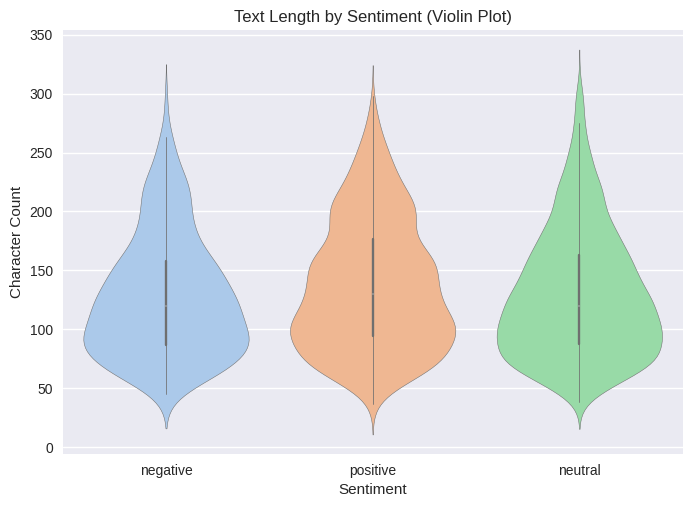

In [98]:
sns.violinplot(x='sentiment', y='text_length_chars', data=df, hue='sentiment', palette='pastel', legend=False)
plt.title('Text Length by Sentiment (Violin Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')
plt.show()

### 5.3 Remove Unnecessary Text Statistics Columns

In [99]:
df = df.drop(['text_length_chars', 'text_length_words'], axis=1)

## 6. Further Preprocessing - Extraction of Named Entity Recognition (NER) & Domain-Specific Characteristics

Pipeline: <br>
    - NER: Extracts entities from cleaned text and adds those entities to a new column called ```entities```. <br>
    - FinBERT: Finance related tokenisation already done in ```clean_text```, workflow here allows memory optimisation by using batches. <br>
spaCy's NER works on the original, human-readable text. FinBERT's tokenization breaks text into subword tokens that would be meaningless to spaCy's NER model.

### 6.1 NER

In [100]:
# nlp = spacy.load("en_core_web_trf")

# def extract_entities(text):
#     """Extract named entities from text using spaCy"""
#     doc = nlp(text)
#     entities = [(ent.text, ent.label_) for ent in doc.ents]
#     return entities

# # Apply NER extraction to all texts
# df['entities'] = df['text'].apply(extract_entities)

# # Show some examples
# for i in range(3):
#     print(f"\nText: {df.iloc[i]['text'][:100]}...")
#     print(f"Entities: {df.iloc[i]['entities']}")

In [101]:
df.head()

,text,sentiment,confidence
0,Sales in Finland decreased by 10.5% in January...,negative,1.0
1,"Mika Stahl berg, VP F-Secure Labs, said, ` We ...",positive,1.0
2,Any investment or investment activity to which...,neutral,1.0
3,And that's exactly what happened on a recent w...,neutral,1.0
4,According to a posted by the World Intellectua...,neutral,1.0


### 6.2 Identify Financial Phrases

In [102]:
# ----------------------------------- SETUP ---------------------------------- #
# Define the FinBERT model name
finbert_model_name = "ProsusAI/finbert"

# Initialise tokeniser and FinBERT model
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
finbert_model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name)

# Enable GPU support if available
finbert_model.to(device)

print(f"FinBERT model loaded: {finbert_model_name}")
print(f"  - Model labels: {finbert_model.config.id2label}")
print(f"  - Tokenizer vocab size: {len(finbert_tokenizer)}")
print(f"  - Using device: {'GPU' if device.type == 'cuda' else 'CPU'}")
# ---------------------------------------------------------------------------- #

# ------------------------------- TOKENISATION ------------------------------- #
# Financial-aware tokenization
def finbert_tokenize_batch(texts, tokenizer, max_length=512):
    """
    Batch tokenization optimized for FinBERT. Data cleaning is applied before tokenization.
    Args:
        texts (list of str): List of texts to tokenize.
        tokenizer: FinBERT tokenizer.
        max_length (int): Maximum sequence length for tokenization.
    Returns:
        dict: Tokenized inputs ready for FinBERT.
    """
    # Tokenize with FinBERT
    encoded = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }
# ---------------------------------------------------------------------------- #

# ---------------------- POST PROCESSING AND REFINEMENT ---------------------- #
# UNDERSTAND FIRST
# Phrase validation: Verify extracted phrases against financial dictionaries/ontologies
# Overlap resolution: Handle overlapping phrase candidates
# Context validation: Ensure phrases make sense in their surrounding context
# Length filtering: Remove phrases that are too short or too long to be meaningful

# ---------------------- FINANCIAL PHRASE CATEGORISATION --------------------- #
# Semantic clustering: Group similar financial phrases together
# Domain classification: Categorize phrases by financial domain (accounting, trading, investment, etc.)
# Sentiment association: Link phrases to sentiment indicators if needed

# ----------------------------- QUALITY ASSURANCE ---------------------------- #
# Confidence scoring: Assign confidence scores to identified phrases
# Manual validation: Sample-based human review of extracted phrases
# Performance metrics: Calculate precision, recall, and F1-score against gold standard

# -------------------- INTEGRATION WITH EXISTING PIPELINE -------------------- #
# Feature augmentation: Add identified financial phrases as features to your sentiment analysis
# Phrase embeddings: Generate embeddings for identified phrases using FinBERT
# Domain-specific filtering: Focus on phrases most relevant to your specific financial domain

FinBERT model loaded: ProsusAI/finbert
  - Model labels: {0: 'positive', 1: 'negative', 2: 'neutral'}
  - Tokenizer vocab size: 30522
  - Using device: GPU


### 6.3 Sentiment Patterns Around Financial Phrases & Entities

In [103]:
# # Count entity types by sentiment
# from collections import defaultdict

# entity_stats = defaultdict(lambda: defaultdict(int))

# for idx, row in df.iterrows():
#     sentiment = row['sentiment']
#     for entity_text, entity_label in row['entities']:
#         entity_stats[sentiment][entity_label] += 1

# # Display results
# for sentiment in entity_stats:
#     print(f"\n{sentiment.upper()} - Top entity types:")
#     sorted_entities = sorted(entity_stats[sentiment].items(), 
#                            key=lambda x: x[1], reverse=True)
#     for entity_type, count in sorted_entities[:5]:
#         print(f"  {entity_type}: {count}")

### 6.4 Temporal Patterns

In [104]:
# temporal patterns

# 02. Data Preprocessing and Feature Engineering

**Objective**: Prepare the data for model training by implementing robust preprocessing pipelines.

## 📋 Tasks for you to complete:
2. Tokenization strategy
3. Handling class imbalance
4. Train/validation/test split
5. Feature engineering for financial text

## 🎯 Learning Goals:
- Production-ready data preprocessing
- Domain-specific feature engineering
- Robust data pipeline creation

In [105]:
# TODO: Import preprocessing libraries
# Hint: transformers (tokenizer), sklearn (preprocessing), re, string

## Tokenization and Encoding

In [106]:
# TODO: Set up tokenizer for transformer models
# 1. Choose appropriate tokenizer (DistilBERT, BERT, RoBERTa)
# 2. Configure max_length, padding, truncation
# 3. Handle special tokens

from transformers import AutoTokenizer

# Your tokenizer setup here
MODEL_NAME = "distilbert-base-uncased"  # or your choice
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_texts(texts, max_length=512):
    """
    Tokenize texts for transformer models.
    
    Args:
        texts (list): List of texts to tokenize
        max_length (int): Maximum sequence length
        
    Returns:
        dict: Tokenized inputs
    """
    # Your implementation here
    pass

## Label Encoding and Class Handling

In [107]:
# TODO: Handle sentiment labels
# 1. Encode sentiment labels to numbers
# 2. Check class distribution
# 3. Implement class balancing strategy if needed

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

def encode_labels(sentiments):
    """
    Encode sentiment labels to numerical values.
    
    Args:
        sentiments (list): List of sentiment labels
        
    Returns:
        tuple: (encoded_labels, label_encoder)
    """
    # Your implementation here
    pass

def calculate_class_weights(labels):
    """
    Calculate class weights for handling imbalanced data.
    
    Args:
        labels (array): Encoded labels
        
    Returns:
        dict: Class weights
    """
    # Your implementation here
    pass

## Financial Feature Engineering

In [108]:
# TODO: Extract financial domain features
# 1. Financial keywords presence
# 2. Numerical patterns (percentages, currencies)
# 3. Sentiment-bearing word counts
# 4. Text complexity metrics

def extract_financial_features(text):
    """
    Extract financial domain-specific features.
    
    Args:
        text (str): Input text
        
    Returns:
        dict: Financial features
    """
    features = {}
    
    # Financial keywords
    financial_keywords = [
        'revenue', 'profit', 'loss', 'earnings', 'growth', 
        'decline', 'increase', 'decrease', 'market', 'stock'
    ]
    
    # Your feature extraction here
    # Example:
    # features['has_percentage'] = bool(re.search(r'\d+%', text))
    # features['has_currency'] = bool(re.search(r'\$\d+', text))
    
    return features

# Test your function
sample_text = "Revenue increased by 15% to $2.5M this quarter"
print(extract_financial_features(sample_text))

{}


## Data Splitting Strategy

In [109]:
# TODO: Implement stratified data splitting
# 1. Train/validation/test split (70/15/15 or 80/10/10)
# 2. Ensure stratification by sentiment class
# 3. Set random seeds for reproducibility

from sklearn.model_selection import train_test_split

def split_data(texts, labels, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split data into train/validation/test sets with stratification.
    
    Args:
        texts (list): List of texts
        labels (array): Encoded labels
        test_size (float): Test set proportion
        val_size (float): Validation set proportion  
        random_state (int): Random seed
        
    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # Your implementation here
    pass

## Data Pipeline Integration

In [110]:
# TODO: Create complete preprocessing pipeline
# 1. Combine all preprocessing steps
# 2. Save processed data
# 3. Create data loaders for training

class FinancialDataProcessor:
    """
    Complete data preprocessing pipeline for financial sentiment analysis.
    """
    
    def __init__(self, model_name="distilbert-base-uncased", max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = None
        self.label_encoder = None
        
    def fit(self, texts, labels):
        """
        Fit the processor on training data.
        
        Args:
            texts (list): Training texts
            labels (list): Training labels
        """
        # Your implementation here
        pass
    
    def transform(self, texts, labels=None):
        """
        Transform texts and labels.
        
        Args:
            texts (list): Texts to transform
            labels (list, optional): Labels to transform
            
        Returns:
            dict: Processed data
        """
        # Your implementation here
        pass
    
    def save(self, path):
        """
        Save the processor state.
        
        Args:
            path (str): Save path
        """
        # Your implementation here
        pass

## Data Quality Validation

In [111]:
# TODO: Implement data validation checks
# 1. Check for data leakage between splits
# 2. Validate tokenization results
# 3. Ensure label distribution consistency
# 4. Check for edge cases

def validate_preprocessing(train_data, val_data, test_data):
    """
    Validate preprocessing results.
    
    Args:
        train_data (dict): Training data
        val_data (dict): Validation data
        test_data (dict): Test data
        
    Returns:
        dict: Validation results
    """
    validation_results = {}
    
    # Your validation checks here
    # Example checks:
    # - No text overlap between splits
    # - Token sequence lengths are within limits
    # - Label distributions are reasonable
    
    return validation_results

## Save Processed Data

In [112]:
# TODO: Save processed datasets
# 1. Save train/val/test splits
# 2. Save preprocessing artifacts (tokenizer, label encoder)
# 3. Create data manifest/metadata file

import pickle
import json
from pathlib import Path

def save_processed_data(data_dict, save_dir="../data/processed"):
    """
    Save processed data and metadata.
    
    Args:
        data_dict (dict): Processed data
        save_dir (str): Save directory
    """
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True)
    
    # Your save implementation here
    pass

# Usage example:
# save_processed_data({
#     'train': train_data,
#     'val': val_data,
#     'test': test_data,
#     'metadata': metadata
# })

## 💡 Implementation Hints:

### Text Cleaning:
```python
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Handle financial symbols
    text = re.sub(r'\$([0-9,]+)', r'MONEY_\1', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
```

### Tokenization:
```python
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
encoded = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)
```

### Class Weights:
```python
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
```